# The Black-Scholes-Model using Neural Networks

We will here use Python to learn the Black-Scholes option pricing model from simulated data. If this is possible to achieve with high accuracy, then it suggests that market data may be used to train an option pricing model that better matches market prices than the BSM. For the training part, we are going to implement a simple feed forward neural network using Keras to approximate the Black Scholes formula.

First we import our packages:

In [1]:
import pylab
import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import random

import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Activation, Dense, Dropout, Flatten

## The Black-Scholes-Merton Model

Firstly we define our call and put option. We need this in order to calculate the prices generated by our dataset.

In [2]:
def euro_vanilla(S, K, T, r, sigma):
    d1 = (np.log(S/K)+(r+0.5*sigma**2)*(T))/(sigma*np.sqrt(T))
    d2 = (np.log(S/K)+(r-0.5*sigma**2)*(T))/(sigma*np.sqrt(T))
    
    result = S*norm.cdf(d1, 0.0, 1.0)-K*np.exp(-r*(T))*norm.cdf(d2, 0.0, 1.0)
    
    return result

## Create the Dataset

Create a set of random variables for S, K, T, r and Sigma. The dataset will consist of 1,000,000 random options (both put and call)

In [3]:
random.seed(42) #to make sure that we get the same output every time
draws = 1000000
S = np.random.rand(draws)*100
K = (np.random.randint(50, 150, draws) * .01) * S
T = np.random.randint(10, 300, draws) / 100
r = np.random.randint(1, 1000, draws) / 10000
sigma = np.random.randint(1, 50, draws) / 100

Create the dataset and its corresponding option prices:

In [4]:
%%time

opt_price = []
for i in range(draws):
    p = euro_vanilla(S[i], K[i], T[i], r[i], sigma[i])
    opt_price.append(p)
    if (i % 50000) == 0:
        print('Generated {} Options'.format(i))

Generated 0 Options
Generated 50000 Options
Generated 100000 Options
Generated 150000 Options
Generated 200000 Options
Generated 250000 Options
Generated 300000 Options
Generated 350000 Options
Generated 400000 Options
Generated 450000 Options
Generated 500000 Options
Generated 550000 Options
Generated 600000 Options
Generated 650000 Options
Generated 700000 Options
Generated 750000 Options
Generated 800000 Options
Generated 850000 Options
Generated 900000 Options
Generated 950000 Options
CPU times: user 3min 44s, sys: 4.35 s, total: 3min 48s
Wall time: 3min 59s


Create our dataset with corresponding headlines: 

In [5]:
options = pd.DataFrame({'S': S,
                        'K': K,
                        'T': T,
                        'r': r,
                        'sigma': sigma,
                        'call price': opt_price})

#print(options.tail())

The Black Scholes formula for a European call option is linearly homogenous with respect to the stock price. Therfore, we can normalize the data by dividing the price of the stock and the price of the call option by the strike price.

In [6]:
options['S'] = options['S'].div(options.K)
options['call price'] = options['call price'].div(options.K)
options['K'] = options['K'].div(options.K)

#print(options.tail())

Move the data into a numpy array

In [7]:
prices = options.values

Determin a Train/Test Split

In [8]:
# X values
X = prices[:, :5]

# Y values
y = prices[:, 5:6]

# Use Sklearn library to randomly split data into training/testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#one can check the size of the datasets by using ".shape".

## Build the Keras (Tensorflow) model:

In [9]:
input_size = 5
output_size = 1
hidden_layer_size = 50

model = tf.keras.Sequential([
                            #Hidden layer 1
                            tf.keras.layers.Dense(hidden_layer_size, activation='relu'),
                            #Hidden layer 2
                            tf.keras.layers.Dense(hidden_layer_size, activation='relu'),
                            #Hidden layer 3
                            tf.keras.layers.Dense(hidden_layer_size, activation='relu'),
                            #Output layer
                            tf.keras.layers.Dense(output_size, activation='elu')
                            ])

Choose the optimizer and the loss function

In [10]:
# optimizer = adam, rmsprop
model.compile(optimizer = 'adam', loss = 'mse', metrics=['accuracy'])

## Train the model

Stop training if cost function (val_loss) using cross validation data fails to decrease

In [11]:
callbacks_list = [EarlyStopping(monitor = 'val_loss', patience = 3)]

In [12]:
NUM_EPOCHS = 100

model.fit(X_train, y_train, epochs = NUM_EPOCHS, validation_split=0.1, batch_size=100, verbose=2,
         callbacks=callbacks_list)

Train on 720000 samples, validate on 80000 samples
Epoch 1/100
720000/720000 - 32s - loss: 2.7022e-04 - accuracy: 0.0090 - val_loss: 1.1919e-05 - val_accuracy: 0.0082
Epoch 2/100
720000/720000 - 28s - loss: 2.0763e-05 - accuracy: 0.0090 - val_loss: 2.9543e-05 - val_accuracy: 0.0082
Epoch 3/100
720000/720000 - 27s - loss: 1.3628e-05 - accuracy: 0.0090 - val_loss: 3.9516e-06 - val_accuracy: 0.0082
Epoch 4/100
720000/720000 - 25s - loss: 1.0128e-05 - accuracy: 0.0090 - val_loss: 4.4785e-06 - val_accuracy: 0.0082
Epoch 5/100
720000/720000 - 28s - loss: 7.7975e-06 - accuracy: 0.0090 - val_loss: 1.1148e-05 - val_accuracy: 0.0082
Epoch 6/100
720000/720000 - 29s - loss: 6.6275e-06 - accuracy: 0.0090 - val_loss: 4.6892e-06 - val_accuracy: 0.0082


In [13]:
predictions = model.predict(X_test)

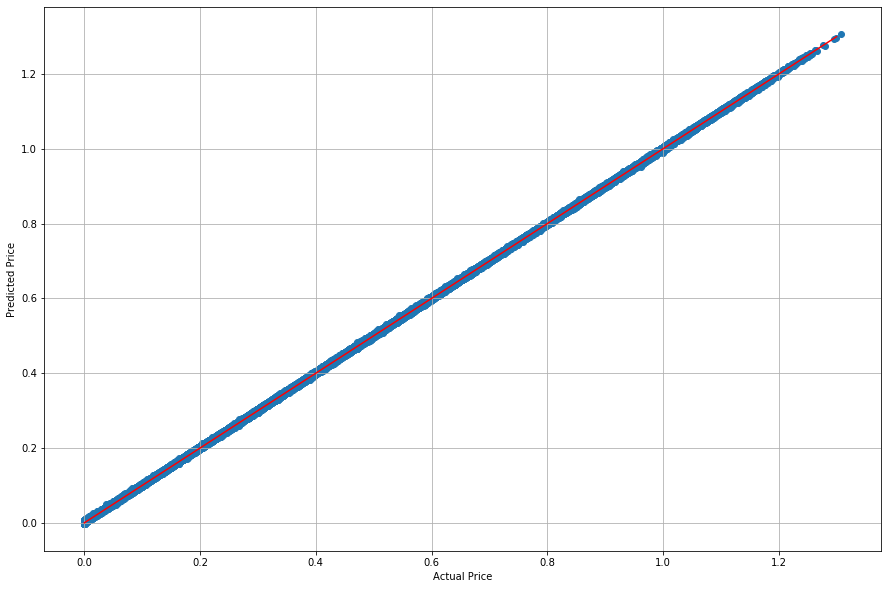

In [14]:
plt.figure(figsize = (15,10))
plt.scatter(y_test, predictions)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.plot([0,1.3], [0,1.3], 'r')
plt.grid(True)

The value of having a validation set is significant and is a vital step to understand how well your model is training. Ideally on a curve you want your training accuracy to be close to your validation curve, and the moment your validation curve falls below your training curve the alarm bells should go off and your model is probably busy over-fitting.

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


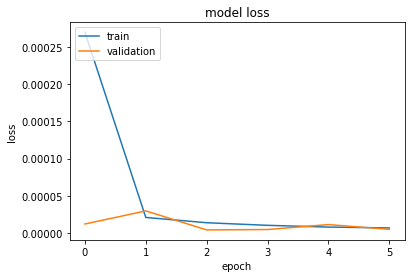

In [15]:
print(model.history.history.keys())

plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

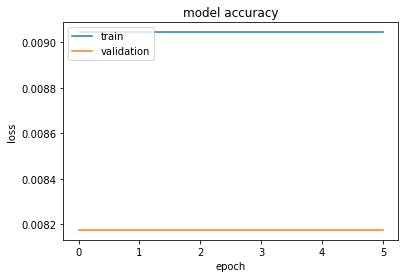

In [16]:
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()